<a href="https://colab.research.google.com/github/cgurkan/fake-news/blob/main/FakeNewsPreprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install text-hammer
!pip install cleantext

In [6]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt 
import seaborn as sns
import math

BASE_URL = "/content/drive/MyDrive/Colab Notebooks/fakenews/"

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
df_train = pd.read_csv(BASE_URL+"data/train/Task3_english_training.csv")
df_train.head()

,public_id,text,title,our rating
0,5a228e0e,Distracted driving causes more deaths in Canad...,"You Can Be Fined $1,500 If Your Passenger Is U...",FALSE
1,30c605a1,Missouri politicians have made statements afte...,Missouri lawmakers condemn Las Vegas shooting,partially false
2,c3dea290,Home Alone 2: Lost in New York is full of viol...,CBC Cuts Donald Trump's 'Home Alone 2' Cameo O...,partially false
3,f14e8eb6,But things took a turn for the worse when riot...,Obama’s Daughters Caught on Camera Burning US ...,FALSE
4,faf024d6,It’s no secret that Epstein and Schiff share a...,Leaked Visitor Logs Reveal Schiff’s 78 Visits ...,FALSE


In [9]:
df_test = pd.read_csv(BASE_URL+"data/test/English_data_test_release_with_rating.csv")
df_test.head()

,ID,text,title,our rating
0,122653045997905671927713471889615536378,The deputy secretary at the US Treasury has sa...,US Treasury deputy sec warns that shortages li...,Partially false
1,275389285957305997321446227088442471741,KABUL—Approximately twelve minutes after U.S. ...,CNN Praises Taliban For Wearing Masks During A...,Other
2,333248764296609831067233855420575814716,The vast majority of (oblivious) Americans hav...,Tennessee Has Just LEGALIZED Government COVID ...,false
3,264019763253447756851916399533799891538,(Natural News) There’s a secret layer of infor...,MEDICAL SHOCKER: Scientists at Sloan Kettering...,false
4,158073737187690682830899773280916034317,"A recent study reported by the NCBI, which is ...",Study Results: Facemasks are Ineffective to Bl...,false


In [10]:
print(f"Training Data Shape: {df_train.shape}\nTest Data Shape: {df_test.shape}")

Training Data Shape: (900, 4)
Test Data Shape: (612, 4)


In [11]:
#Drop public_id column bot train and test dataset
df_train.drop(labels='public_id', axis=1, inplace=True)
df_test.drop(labels='ID', axis=1, inplace=True)

In [12]:
#Rename target column to "label"
df_train.rename(columns={"our rating":"label"}, inplace=True)
df_test.rename(columns={"our rating":"label"}, inplace=True)

In [13]:
df_train['label'] = df_train.label.map({'TRUE': 1, 'True':1, 'FALSE': 0, 'false':0, 'partially false': 2, 'Partially false': 2, 'other': 3, 'Other': 3})
df_train["label_name"] = df_train.label.map({0: 'False', 1:'True', 2:'Partially False',  3:'Other'})

In [14]:
df_test['label'] = df_test.label.map({'TRUE': 1, 'True':1, 'FALSE': 0, 'false':0, 'partially false': 2, 'Partially false': 2, 'other': 3, 'Other': 3})
df_test["label_name"] = df_test.label.map({0:'False', 1:'True', 2:'Partially False',  3:'Other'})

In [15]:
#clear NaN values with space, we don't use title
df_train['title'] = df_train['title'].replace(math.nan,' ')
df_test['title'] = df_test['title'].replace(math.nan,' ')


#concatenate text and title columns
df_train["news"] = df_train["title"] + ' ' + df_train["text"]
df_test["news"] = df_test["title"] + ' ' + df_test["text"]

In [13]:
df_train['num_words'] = df_train['news'].apply(lambda x:len(x.split()))

# Data Preprocessing

## Cleaning

In [16]:
import text_hammer as th

In [17]:
%%time
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

def text_preprocessing(df, col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_stopwords(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

CPU times: user 1.46 ms, sys: 924 µs, total: 2.38 ms
Wall time: 12 ms


In [18]:
cleaned_df = text_preprocessing(df_train, "news")

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

In [21]:
cleaned_df_test = text_preprocessing(df_test, "news")

  0%|          | 0/612 [00:00<?, ?it/s]

  0%|          | 0/612 [00:00<?, ?it/s]

  0%|          | 0/612 [00:00<?, ?it/s]

  0%|          | 0/612 [00:00<?, ?it/s]

  0%|          | 0/612 [00:00<?, ?it/s]

  0%|          | 0/612 [00:00<?, ?it/s]

  0%|          | 0/612 [00:00<?, ?it/s]

  0%|          | 0/612 [00:00<?, ?it/s]

In [18]:
#cleaned_df['num_words'] = cleaned_df['news'].apply(lambda x: len(x.split()))

# Modelling

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics import classification_report , confusion_matrix
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest,chi2,f_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn import tree
from sklearn.metrics import classification_report , confusion_matrix,accuracy_score,f1_score,roc_curve
from xgboost import XGBClassifier

#Data Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go 

In [22]:
X_train,X_test,y_train,y_test = cleaned_df.news, cleaned_df_test.news, cleaned_df.label, cleaned_df_test.label

In [23]:
X_train.shape, X_test.shape

((900,), (612,))

In [30]:
vectorizer = TfidfVectorizer()
vector =  vectorizer.fit_transform(X_train)
x_train=vector.toarray()

vector2 = vectorizer.transform(X_test)
x_test=vector2.toarray()

In [31]:
x_train.shape

(900, 27750)

In [28]:
selector = SelectKBest()
x_train = selector.fit_transform(x_train, y_train)
x_test = selector.fit_transform(x_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [    1     2     4 ... 27746 27748 27749] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [29]:
x_train.shape

(900, 10)

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = (np.trace(cf) / float(np.sum(cf))) * 100

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.2f} %\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

## NaiveBayes

In [46]:
mnb = MultinomialNB()
mnb.fit(x_train, y_train)
mnb.score(x_train,y_train),mnb.score(x_test,y_test)

(0.5188888888888888, 0.5147058823529411)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.51      1.00      0.68       315
           1       0.00      0.00      0.00       210
           2       0.00      0.00      0.00        56
           3       0.00      0.00      0.00        31

    accuracy                           0.51       612
   macro avg       0.13      0.25      0.17       612
weighted avg       0.26      0.51      0.35       612



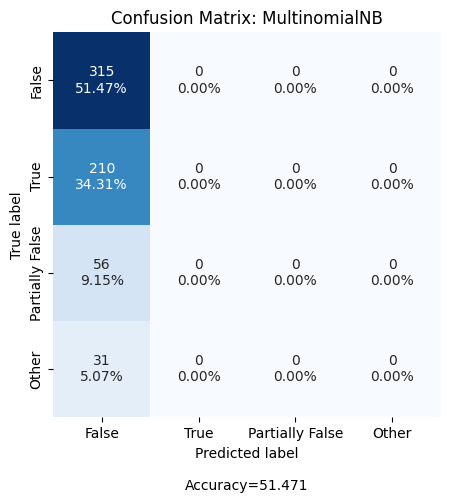

In [48]:
y_pred=mnb.predict(x_test)
print(classification_report(y_test,y_pred))
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['False','True', 'Partially False', 'Other']
#sns.heatmap(confusion_matrix(y_act,y_pred),annot=True,cmap='Spectral', fmt='g')
cf_matrix_1 = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix_1, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(5,5),cbar=False, title='Confusion Matrix: MultinomialNB')

## Decision Tree classifier

In [49]:
model2 = DecisionTreeClassifier(criterion='gini',splitter='random',min_samples_leaf=70,max_depth=4,random_state=0)
model2.fit(x_train, y_train)
print(model2.score(x_train, y_train))
print(model2.score(x_test,y_test))

0.52
0.4624183006535948


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.59      0.84      0.69       315
           1       0.00      0.00      0.00       210
           2       0.12      0.34      0.18        56
           3       0.00      0.00      0.00        31

    accuracy                           0.46       612
   macro avg       0.18      0.29      0.22       612
weighted avg       0.31      0.46      0.37       612



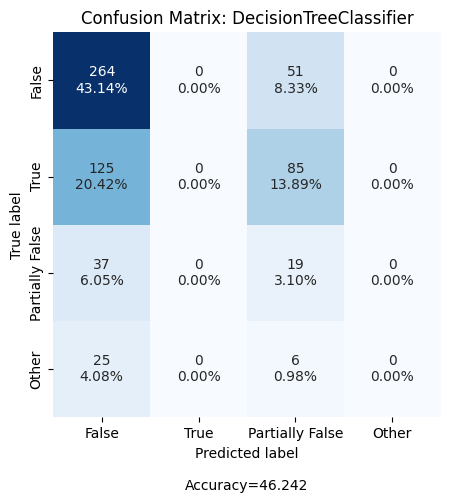

In [50]:
#confusion matrix and classification report
y_pred=model2.predict(x_test)
print(classification_report(y_test, y_pred))
cf_matrix_2 = confusion_matrix(y_test, y_pred)
#sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap='summer', fmt='g')
make_confusion_matrix(cf_matrix_2, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(5,5),cbar=False, title='Confusion Matrix: DecisionTreeClassifier')

## RandomForest

In [51]:
classifiers = RandomizedSearchCV(RandomForestClassifier(),{'n_estimators':[4,5],'criterion':['entropy'],
                                                      'max_depth':range(1,4),'min_samples_split':range(2,5)},random_state=12)
classifiers.fit(x_train, y_train)
print('Training score:',classifiers.score(x_train, y_train))
print('Testing score:',classifiers.score(x_test,y_test))
print(classifiers.best_estimator_)

Training score: 0.5477777777777778
Testing score: 0.5147058823529411
RandomForestClassifier(criterion='entropy', max_depth=3, min_samples_split=4,
                       n_estimators=4)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.52      0.99      0.68       315
           1       0.00      0.00      0.00       210
           2       0.29      0.07      0.11        56
           3       0.00      0.00      0.00        31

    accuracy                           0.51       612
   macro avg       0.20      0.26      0.20       612
weighted avg       0.29      0.51      0.36       612



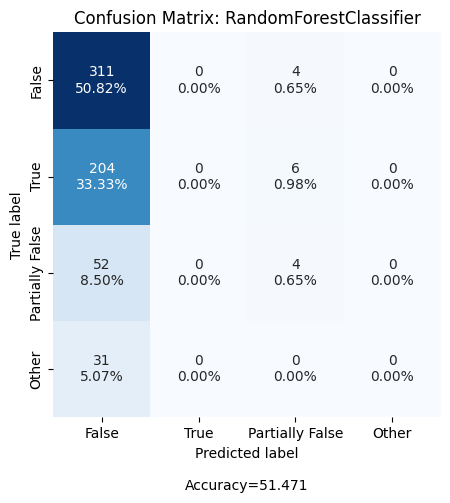

In [54]:
#confusion matrix and classification report
y_pred=classifiers.predict(x_test)
print(classification_report(y_test,y_pred))
#sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap='Spectral', fmt='g')
cf_matrix_3 = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix_3, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(5,5),cbar=False, title='Confusion Matrix: RandomForestClassifier')

## GradientBoosting Classifier

In [55]:
model3 = RandomizedSearchCV(GradientBoostingClassifier(),{"learning_rate": range(3,5),
                "max_depth":[200],"max_features":range(6,10,2),
                 "n_estimators":[10]},random_state=8,n_jobs=-1)
model3.fit(x_train,y_train)
print('Training score:',model3.score(x_train,y_train))
print('Testing score:',model3.score(x_test,y_test))
model3.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training score: 0.9988888888888889
Testing score: 0.4264705882352941


{'n_estimators': 10, 'max_features': 8, 'max_depth': 200, 'learning_rate': 3}

              precision    recall  f1-score   support

           0       0.55      0.73      0.62       315
           1       0.39      0.11      0.17       210
           2       0.06      0.12      0.08        56
           3       0.05      0.03      0.04        31

    accuracy                           0.43       612
   macro avg       0.26      0.25      0.23       612
weighted avg       0.42      0.43      0.39       612



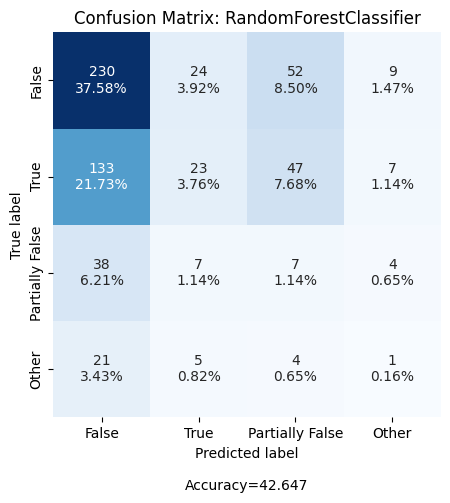

In [57]:
#confusion matrix and classification report
y_pred=model3.predict(x_test)
print(classification_report(y_test,y_pred))
#sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap='PRGn', fmt='g')
cf_matrix_4 = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix_4, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(5,5),cbar=False, title='Confusion Matrix: RandomForestClassifier')

## XGBoost classifier

In [58]:
model = XGBClassifier( eval_metric='map',max_depth=200,n_estimators=70,learning_rate=1.99)
model.fit(x_train,y_train)
print('Training score:',model.score(x_train,y_train))
print('Testing score:',model.score(x_test,y_test))

Training score: 0.9988888888888889
Testing score: 0.48366013071895425


              precision    recall  f1-score   support

           0       0.59      0.80      0.68       315
           1       0.56      0.14      0.23       210
           2       0.12      0.21      0.15        56
           3       0.03      0.03      0.03        31

    accuracy                           0.48       612
   macro avg       0.33      0.30      0.27       612
weighted avg       0.51      0.48      0.45       612



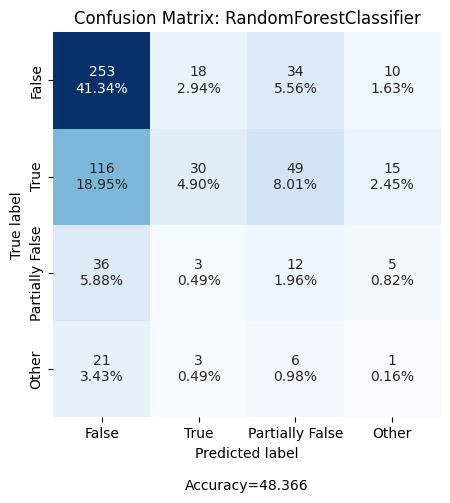

In [59]:
#confusion matrix and classification report
y_pred = model.predict(x_test)
print(classification_report(y_test,y_pred))
#sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap='Spectral', fmt='g')
cf_matrix_5 = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix_5, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(5,5),cbar=False, title='Confusion Matrix: RandomForestClassifier')

## Ada_Boost(Random Forest)

In [60]:
RandomForest = RandomForestClassifier(criterion='entropy', max_depth=3, min_samples_split=5, n_estimators=5)
AddaBoosts = AdaBoostClassifier(base_estimator =RandomForest,n_estimators=70,learning_rate=2.38,random_state=1)
AddaBoosts.fit(x_train,y_train)
print('Training score:',AddaBoosts.score(x_train,y_train))
print('Testing score:',AddaBoosts.score(x_test,y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training score: 0.6255555555555555
Testing score: 0.4950980392156863


              precision    recall  f1-score   support

           0       0.52      0.94      0.67       315
           1       0.25      0.00      0.01       210
           2       0.14      0.09      0.11        56
           3       0.00      0.00      0.00        31

    accuracy                           0.50       612
   macro avg       0.23      0.26      0.20       612
weighted avg       0.37      0.50      0.36       612



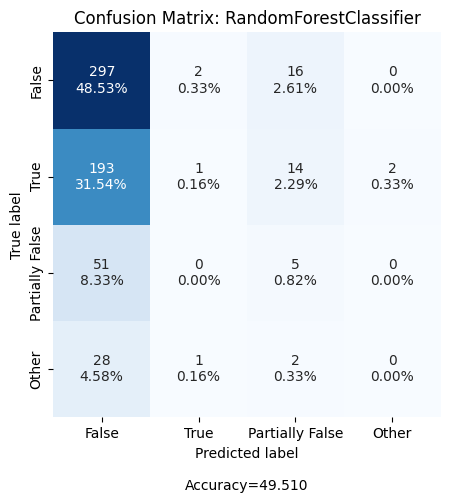

In [62]:
#confusion matrix and classification report
y_pred = AddaBoosts.predict(x_test)
#sns.heatmap(confusion_matrix(y_act,y_pred),annot=True,cmap='PRGn', fmt='g')
print(classification_report(y_test,y_pred))
cf_matrix_6 = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix_6, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(5,5),cbar=False, title='Confusion Matrix: AdaBoostClassifier')

In [ ]:
bels

## AddaBoost(Decision Tree)

In [63]:
Decision_tree = DecisionTreeClassifier(max_depth=200, min_samples_leaf=13, random_state=1)
AdaBoost = AdaBoostClassifier(base_estimator = Decision_tree,n_estimators=70,learning_rate=2,random_state=1)
AdaBoost.fit(x_train, y_train)
print('Training score:',AdaBoost.score(x_train, y_train))
print('Testing score:',AdaBoost.score(x_test,y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training score: 0.97
Testing score: 0.5163398692810458


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
#confusion matrix and classification report
y_pred = AdaBoost.predict(x_test)
#sns.heatmap(confusion_matrix(y_act,y_pred),annot=True,cmap='Spectral', fmt='g')
print(classification_report(y_test,y_pred))
cf_matrix_7 = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix_7, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(5,5),cbar=False, title='Confusion Matrix: AdaBoostClassifier')


In [70]:
y_proba=AdaBoost.predict_proba(x_test)

In [65]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

In [66]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [67]:
def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

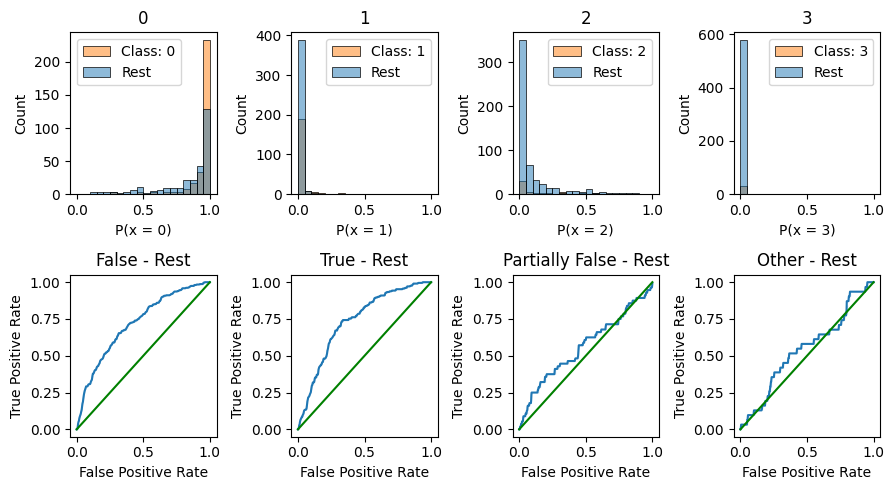

In [133]:

def plot_multiclass_roc_curve(classes, cleaned_df_test, y_proba, y_test):
  # Plots the Probability Distributions and the ROC Curves One vs Rest
  plt.figure(figsize = (9, 5))
  bins = [i/20 for i in range(20)] + [1]
  classes = AdaBoost.classes_
  roc_auc_ovr = {}
  #fig, ax_bottom = plt.subplots(1, 4, figsize=(5, 4))   
  for i in range(len(classes)):
      # Gets the class
      c = classes[i]
      
      # Prepares an auxiliar dataframe to help with the plots
      df_aux = cleaned_df_test.copy()
      df_aux['class'] = [1 if y == c else 0 for y in y_test]
      df_aux['prob'] = y_proba[:, i]
      df_aux = df_aux.reset_index(drop = True)    
      
      # Plots the probability distribution for the class and the rest
      ax = plt.subplot(2, 4, i+1)
      sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
      ax.set_title(c)
      ax.legend([f"Class: {c}", "Rest"])
      ax.set_xlabel(f"P(x = {c})")
      
      # Calculates the ROC Coordinates and plots the ROC Curves
      ax_bottom = plt.subplot(2, 4, i+5)    
      tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
      plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
      ax_bottom.set_title(f"{categories[i]} - Rest")
      
      # Calculates the ROC AUC OvR
      roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
  plt.tight_layout()

plot_multiclass_roc_curve(labels, cleaned_df_test, y_proba, y_test)

In [129]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovr:
    avg_roc_auc += roc_auc_ovr[k]
    i += 1
    print(f"{categories[k]} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
print(f"average ROC AUC OvR: {avg_roc_auc/i:.4f}")

False ROC AUC OvR: 0.7192
True ROC AUC OvR: 0.7346
Partially False ROC AUC OvR: 0.5635
Other ROC AUC OvR: 0.5444
average ROC AUC OvR: 0.6404


In [124]:
# Compares with sklearn (average only)
# "Macro" average = unweighted mean
roc_auc_score(y_test, y_proba, labels = classes, multi_class = 'ovr', average = 'macro')

0.640441719395084